In [ ]:
STRATEGIE DE TRADING AVEC ML & IA

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from fredapi import Fred
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sqlalchemy import create_engine
from sqlalchemy.types import Date
import urllib.parse
import pymysql   jupyter nbconvert Trade_ML_IA.ipynb --to html


In [ ]:
"""PARAMETRES UTILISES"""

TICKER = "^GSPC"
FWD_H = 1
START, END = "2018-01-02", "2020-12-31"
START_COMMON = "2018-01-02"
END_COMMON = "2020-07-17"
fred = Fred(api_key="647427cf56b3b2ed607cbb90a8c76bef")


DONNEES DE MARCHE

In [ ]:

tk = yf.Ticker(TICKER)
px = tk.history(start=START, end=END, interval="1d")["Close"].dropna()
px.name = "close"

fwd_ret = px.shift(-FWD_H) / px - 1.0
fwd_ret.name = f"fwd_ret_{FWD_H}d"

DONNEES MACRO FED

In [ ]:

cpi = fred.get_series("CPIAUCSL").rename("cpi").dropna()
vix = fred.get_series("VIXCLS").rename("vix").dropna()
usdeur = fred.get_series("DEXUSEU").rename("usdeur").dropna()

NORMALISATION DES DATES

In [ ]:

def to_date_index(s: pd.Series):
    s = s.copy()
    idx = pd.to_datetime(s.index)
    if idx.tz is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    s.index = idx.normalize()
    return s[~s.index.duplicated(keep="last")]

# Appliquer
px = to_date_index(px)
fwd_ret = to_date_index(fwd_ret)
cpi = to_date_index(cpi)
vix = to_date_index(vix)
usdeur = to_date_index(usdeur)

BASE DE DONNEES PRINCIPALE 2018-2020

In [ ]:

cal = pd.date_range(start=START_COMMON, end=END_COMMON, freq="B")
df = pd.DataFrame(index=cal)
df["close"] = px.reindex(cal).ffill()
df["fwd_ret"] = fwd_ret.reindex(cal).ffill()
df["vix"] = vix.reindex(cal).ffill()
df["cpi"] = cpi.reindex(cal).ffill()
df["usdeur"] = usdeur.reindex(cal).ffill()
df["cpi_change"] = df["cpi"].pct_change()   #Variation mensuelle de l'IPC

# Traitement CPI 
# 1. Passer le CPI en fin de mois
 #cpi_monthly = cpi.resample("M").last()

# 2. Variation mensuelle
cpi_change_monthly = cpi.pct_change()
cpi_change_monthly.name = "cpi_change"

# 3. Étendre les valeurs sur tous les jours ouvrés du calendrier
cpi_daily = cpi.reindex(cal, method="ffill")
cpi_change_daily = cpi_change_monthly.reindex(cal, method="ffill").bfill()

# 4. Injection dans la base principale
#df["cpi"] = cpi_daily
df["cpi_change"] = cpi_change_daily


LABEL TERNIAIRE SELON FWD RET

In [ ]:

q_low, q_high = df["fwd_ret"].quantile([0.05, 0.95])
def ternary_shock_label(x):
    if x <= q_low: return -1
    elif x >= q_high: return 1
    return 0

df["shock_px_ternary"] = df["fwd_ret"].apply(ternary_shock_label)
df["shock_label"] = df["shock_px_ternary"].map({1: "BUY", -1: "SELL", 0: "HOLD"})


INDICATEUR CHARTISTE

In [ ]:

def compute_RSI(data, window=14):
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    
    return 100 - (100 / (1 + rs))


df["RSI"] = compute_RSI(df["close"])
df["RSI_signal"] = np.where(df["RSI"] < 30, "BUY", np.where(df["RSI"] > 70, "SELL", "HOLD"))

exp1 = df["close"].ewm(span=12, adjust=False).mean()
exp2 = df["close"].ewm(span=26, adjust=False).mean()


df["MACD"] = exp1 - exp2
df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["MACD_trade_signal"] = np.where(df["MACD"] > df["MACD_signal"], "BUY",
                                   np.where(df["MACD"] < df["MACD_signal"], "SELL", "HOLD"))


sma = df["close"].rolling(20).mean()
std = df["close"].rolling(20).std()

df["BB_Upper"] = sma + 2 * std
df["BB_Lower"] = sma - 2 * std
df["BB_signal"] = np.where(df["close"] < df["BB_Lower"], "BUY",
                           np.where(df["close"] > df["BB_Upper"], "SELL", "HOLD"))


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_indicators_separately(df):
    df = df.copy()
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['index'])

    # Créer les sous-graphes : 3 lignes, 1 colonne

    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.5, 0.25, 0.25],
        subplot_titles=("Prix + Bandes de Bollinger", "RSI", "MACD")
    )

    # Row 1: Prix + Bollinger Bands 
    
    fig.add_trace(go.Scatter(
        x=df['date'], y=df['close'],
        name='Prix',
        line=dict(color='black')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=df['date'], y=df['BB_Upper'],
        name='BB Upper',
        line=dict(color='orange', dash='dot')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=df['date'], y=df['BB_Lower'],
        name='BB Lower',
        line=dict(color='orange', dash='dot')
    ), row=1, col=1)

    #  Row 2: RSI 
    fig.add_trace(go.Scatter(
        x=df['date'], y=df['RSI'],
        name='RSI',
        line=dict(color='blue')
    ), row=2, col=1)

    # Lignes 30/70 RSI
    fig.add_hline(y=70, line=dict(color='red', dash='dash'), row=2, col=1)
    fig.add_hline(y=30, line=dict(color='green', dash='dash'), row=2, col=1)

    #  Row 3: MACD 
    fig.add_trace(go.Scatter(
        x=df['date'], y=df['MACD'],
        name='MACD',
        line=dict(color='purple')
    ), row=3, col=1)

    fig.add_trace(go.Scatter(
        x=df['date'], y=df['MACD_signal'],
        name='MACD Signal',
        line=dict(color='gray', dash='dot')
    ), row=3, col=1)

    #  Layout final 
    fig.update_layout(
        height=900,
        title="Indicateurs Techniques : Prix + Bollinger, RSI, MACD",
        template="plotly_white",
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.update_yaxes(title_text="Prix", row=1, col=1)
    fig.update_yaxes(title_text="RSI", row=2, col=1, range=[0, 100])
    fig.update_yaxes(title_text="MACD", row=3, col=1)

    fig.show()


In [ ]:
plot_indicators_separately(df)



REGLES MACROECONOMIQUES

In [ ]:

def macro_signal(row):
    if row["vix"] > 30 or row["cpi_change"] > 0.04 or row["usdeur"] > 1.2:
        return "SELL"
    elif row["vix"] < 15 and row["cpi_change"] < 0.03 and row["usdeur"] < 1.1:
      return "BUY"
    return "HOLD"
df["macro_signal"] = df.apply(macro_signal, axis=1)


SENTIMENT VADER

In [ ]:

# 1. Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')


file_path = "/content/drive/MyDrive/cnbc_headlines.xlsx"

#https://colab.research.google.com/drive/1kvEtmDw_becj3fvC51rCw4x_3OKDdXsj?usp=sharing
#file_path = r"https://colab.research.google.com/drive/1kvEtmDw_becj3fvC51rCw4x_3OKDdXsj?usp=sharing"

try:
    news_df = pd.read_csv(file_path)
except:
    news_df = pd.read_excel(file_path)

def extract_date(time_str):
    match = re.search(r"\w{3},\s+\d{1,2}\s+\w+\s+\d{4}", str(time_str))
    if match:
        try:
            return pd.to_datetime(match.group(0))
        except:
            return None
    return None

news_df["date"] = news_df["Time"].apply(extract_date)
news_df["text"] = news_df["Headlines"].fillna('') + ". " + news_df["Description"].fillna('')
news_clean = news_df.dropna(subset=["date", "text"])

news_clean = news_clean[(news_clean["date"] >= "2018-01-02") & (news_clean["date"] <= "2020-07-17")]

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
news_clean["sentiment"] = news_clean["text"].apply(lambda x: sid.polarity_scores(str(x))["compound"])

# --- Règle de décision ---
def vader_decision_rule(score):
    if score >= 0.05: return 1
    elif score <= -0.05: return -1
    return 0

news_clean["sentiment_label"] = news_clean["sentiment"].apply(vader_decision_rule)

#  Agrégation par date (moyenne journalière) 
sentiment_by_date = (
    news_clean.groupby("date")[["sentiment", "sentiment_label"]]
    .mean()
    .reindex(cal)
    .ffill()
    .rename_axis("date")   # important pour garder la colonne "date"
    .reset_index()
)

sentiment_by_date["sentiment_label"] = (
    sentiment_by_date["sentiment_label"]
    .round()
    .astype("Int64")
)

#  Fusion avec la base principale 
df_with_date = df.reset_index().rename(columns={"index": "date"})
df_with_date["date"] = pd.to_datetime(df_with_date["date"])
sentiment_by_date["date"] = pd.to_datetime(sentiment_by_date["date"])

df_merged = pd.merge(df_with_date, sentiment_by_date, on="date", how="left")

# Sécurisation : remplir au cas où il reste des trous

df_merged["sentiment"] = df_merged["sentiment"].ffill()
df_merged["sentiment_label"] = df_merged["sentiment_label"].ffill().astype("Int64")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CALCUL DU LABEL FINAL

In [ ]:

def ret_score(row):
    signal_map = {"BUY": 1, "SELL": -1, "HOLD": 0}
    signals = [row["RSI_signal"], row["MACD_trade_signal"], row["BB_signal"], row["macro_signal"]]

    if row["usdeur"] > 1.2:
        signals.append("SELL")
    elif row["usdeur"] < 1.1:
        signals.append("BUY")

    if not pd.isna(row["sentiment_label"]):
        signals.append("BUY" if row["sentiment_label"] == 1 else "SELL" if row["sentiment_label"] == -1 else "HOLD")

    score = sum(signal_map.get(s, 0) for s in signals)

    if score > 0:
        return "BUY"
    elif score < 0:
        return "SELL"
    return "HOLD"

df_merged["final_label"] = df_merged.apply(ret_score, axis=1)


In [ ]:
import plotly.graph_objects as go

def plot_vader_sentiment(df_merged):
    df = df_merged.copy()
    df = df.reset_index() if 'date' not in df.columns else df
    df["date"] = pd.to_datetime(df["date"])

    fig = go.Figure()

    #  Sentiment compound (ligne) 
    fig.add_trace(go.Scatter(
        x=df["date"],
        y=df["sentiment"],
        mode="lines",
        name="Score VADER (compound)",
        line=dict(color="black")
    ))

    #  Sentiment label (points colorés) 
    color_map = {1: "green", 0: "gold", -1: "red"}
    label_names = {1: "Positif", 0: "Neutre", -1: "Négatif"}

    for label in [-1, 0, 1]:
        sub = df[df["sentiment_label"] == label]
        fig.add_trace(go.Scatter(
            x=sub["date"],
            y=sub["sentiment"],
            mode="markers",
            marker=dict(color=color_map[label], size=6),
            name=f"Label : {label_names[label]}"
        ))

    #  Mise en page 
    fig.update_layout(
        title="Évolution du Sentiment VADER (2018–2020)",
        xaxis_title="Date",
        yaxis_title="Score de sentiment",
        template="plotly_white",
        hovermode="x unified",
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        height=500
    )

    fig.update_yaxes(range=[-1.05, 1.05])

    fig.show()


In [ ]:
plot_vader_sentiment(df_merged)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

In [ ]:
import plotly.graph_objects as go
import pandas as pd

def plot_interactive_signals(df, date_col='date', price_col='close', signal_col='final_label', title='Backtest de règle de décision'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # Graph principal : ligne des prix
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df[date_col],
        y=df[price_col],
        mode='lines',
        name='Prix',
        line=dict(color='black')
    ))

    # Signaux BUY
    buy_signals = df[df[signal_col] == 'BUY']
    fig.add_trace(go.Scatter(
        x=buy_signals[date_col],
        y=buy_signals[price_col],
        mode='markers',
        name='BUY',
        marker=dict(color='green', size=10, symbol='triangle-up'),
        hovertext='BUY Signal'
    ))

    # Signaux SELL
    sell_signals = df[df[signal_col] == 'SELL']
    fig.add_trace(go.Scatter(
        x=sell_signals[date_col],
        y=sell_signals[price_col],
        mode='markers',
        name='SELL',
        marker=dict(color='red', size=10, symbol='triangle-down'),
        hovertext='SELL Signal'
    ))



    # Mise en forme du graphique
    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title='Prix',
        template='plotly_white',
        hovermode='x unified',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.show()


In [ ]:
plot_interactive_signals(df_merged, date_col='date', price_col='close', signal_col='final_label')


ML - LIGHTGBM

In [ ]:
# infos CPU
import multiprocessing
print("Nombre de cœurs CPU :", multiprocessing.cpu_count())
# infos GPU
import tensorflow as tf
print("GPU disponible :", tf.test.is_gpu_available())
!nvidia-smi
# infos système sous Linux
!cat /proc/cpuinfo
# infos système sous Windows
!type C:\Windows\System32\drivers\etc\hosts

Nombre de cœurs CPU : 2
GPU disponible : False
/bin/bash: line 1: nvidia-smi: command not found
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.158
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_sta

In [ ]:
import lightgbm as lgb
print('Version de lightgbm :', lgb.__version__)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import time

Version de lightgbm : 4.6.0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:
#train = pd.read_excel('/content/drive/MyDrive/cnbc_headlines.xlsx')

In [ ]:
# Dictionnaire de correspondance
encoding_map = {
    "HOLD": 0,
    "BUY": 1,
    "SELL": 2
}

# Appliquer le remplacement à toutes les colonnes sauf 'final_label'
cols_to_encode = df_merged.columns.difference(['final_label'])  # toutes sauf la cible

# Remplacer dans les colonnes concernées
df_merged[cols_to_encode] = df_merged[cols_to_encode].replace(encoding_map)




/tmp/ipython-input-4196191181.py:12: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
# Conversion de la colonne 'date' en datetime (si ce n’est pas déjà fait)
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Extraction des caractéristiques temporelles
df_merged['year']        = df_merged['date'].dt.year
df_merged['month']       = df_merged['date'].dt.month
df_merged['day']         = df_merged['date'].dt.day

# Suppression de la colonne brute 'date' si non utile
# Nous la gardons pour l'instant car elle est utilisée pour l'indexation temporelle dans d'autres cellules (comme le plotting)
# df_merged = df_merged.drop(columns=['date'])

In [ ]:
import pandas as pd
#import lightgbm as lgb

from sklearn.model_selection import train_test_split

# D'abord : split train / temp (train = 70%, temp = 30%)
train_df, temp_df = train_test_split(df_merged, test_size=0.3, stratify=df_merged['final_label'], random_state=42)

SPLIT ET INDEX

In [ ]:
# Étape 2 : split temp en 50% validation, 50% test  chacun fait 15% du total

valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['final_label'],
    random_state=42
)
# Fixer l'index datetime
# Nous allons définir l'index ici pour test_df comme il l'était initialement

test_df.index = pd.to_datetime(test_df[['year', 'month', 'day']])
test_df = test_df.sort_index()

# Pour les autres DataFrames, il peut être utile de définir l'index 'date' aussi
# pour la cohérence si elles sont utilisées dans des fonctions de plotting par la suite.

train_df = train_df.set_index('date').sort_index()
valid_df = valid_df.set_index('date').sort_index()

In [ ]:
print(df_merged.head())
print(df_merged['final_label'].unique())  # elle doit rester inchangée


        date        close   fwd_ret   vix  cpi  usdeur  cpi_change  \
0 2018-01-02  2695.810059  0.006399  9.77  NaN  1.2050    0.004253   
1 2018-01-03  2713.060059  0.004029  9.15  NaN  1.2030    0.004253   
2 2018-01-04  2723.989990  0.007034  9.22  NaN  1.2064    0.004253   
3 2018-01-05  2743.149902  0.001662  9.22  NaN  1.2039    0.004253   
4 2018-01-08  2747.709961  0.001303  9.52  NaN  1.1973    0.004253   

   shock_px_ternary  shock_label  RSI  ...  BB_Upper  BB_Lower  BB_signal  \
0                 0            0  NaN  ...       NaN       NaN          0   
1                 0            0  NaN  ...       NaN       NaN          0   
2                 0            0  NaN  ...       NaN       NaN          0   
3                 0            0  NaN  ...       NaN       NaN          0   
4                 0            0  NaN  ...       NaN       NaN          0   

   macro_signal  sentiment  sentiment_label  final_label  year  month  day  
0             2   0.258843             

In [ ]:
# S'assurer que la colonne est de type 'category'

train_df['final_label'] = train_df['final_label'].astype('category')
valid_df['final_label'] = valid_df['final_label'].astype('category')
test_df['final_label'] = test_df['final_label'].astype('category')


In [ ]:
# Conversion des DataFrames pandas directement en objets DMatrix pour XGBoost

X_train = train_df.drop(columns=['final_label'])
y_train = train_df['final_label'].cat.codes  # conversion des catégories en entiers
X_valid = valid_df.drop(columns=['final_label'])
y_valid = valid_df['final_label'].cat.codes

X_test = test_df.drop(columns=['final_label'])
y_test = test_df['final_label'].cat.codes

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

In [ ]:
params = {
    'device': 'cpu',  # ou 'gpu' si disponible
    'objective': 'multiclass',
    'metric': 'multi_logloss',  # ou 'auc_mu' pour l'AUC multi-classes
    'learning_rate': 0.05,
    'feature_fraction_bynode': 0.75,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'num_leaves': 256,
    'max_depth': 7,
    'verbosity': -1,
    'random_state': 123,
    'num_threads': 4,
    'num_class': 3  #  le nombre réel de classes
}

ENTRAINEMENT DU MODEL

In [ ]:

evals={}
start_time = time.time()
lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_valid], num_boost_round=1000,
                      callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), lgb.record_evaluation(evals)])
print(f"Temps d'exécution: {time.time() - start_time:.2f} secondes")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[243]	valid_0's multi_logloss: 0.3269
Temps d'exécution: 1.30 secondes


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

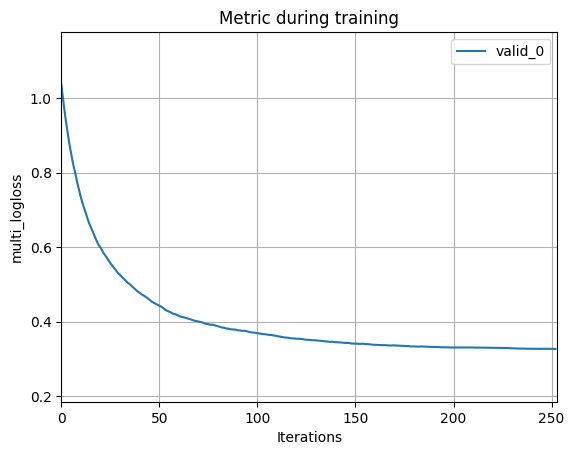

In [ ]:
from lightgbm import plot_metric
plot_metric(evals)

In [ ]:

print(X_train.columns)
print(X_valid.columns)
print(X_test.columns)

Index(['close', 'fwd_ret', 'vix', 'cpi', 'usdeur', 'cpi_change',
       'shock_px_ternary', 'shock_label', 'RSI', 'RSI_signal', 'MACD',
       'MACD_signal', 'MACD_trade_signal', 'BB_Upper', 'BB_Lower', 'BB_signal',
       'macro_signal', 'sentiment', 'sentiment_label', 'year', 'month', 'day'],
      dtype='object')
Index(['close', 'fwd_ret', 'vix', 'cpi', 'usdeur', 'cpi_change',
       'shock_px_ternary', 'shock_label', 'RSI', 'RSI_signal', 'MACD',
       'MACD_signal', 'MACD_trade_signal', 'BB_Upper', 'BB_Lower', 'BB_signal',
       'macro_signal', 'sentiment', 'sentiment_label', 'year', 'month', 'day'],
      dtype='object')
Index(['date', 'close', 'fwd_ret', 'vix', 'cpi', 'usdeur', 'cpi_change',
       'shock_px_ternary', 'shock_label', 'RSI', 'RSI_signal', 'MACD',
       'MACD_signal', 'MACD_trade_signal', 'BB_Upper', 'BB_Lower', 'BB_signal',
       'macro_signal', 'sentiment', 'sentiment_label', 'year', 'month', 'day'],
      dtype='object')


In [ ]:
print(y_valid.isna().sum())
print(y_valid.unique())


0
[0 2 1]


In [ ]:
pred = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)


In [ ]:
print("Classes uniques dans y_valid :", np.unique(y_valid))

Classes uniques dans y_valid : [0 1 2]


In [ ]:
from sklearn.preprocessing import label_binarize

y_valid_binarized = label_binarize(y_valid, classes=[0, 1, 2]) # on doit binariser les classes pour qu'elles fonctionnent dans le modèle
print("Dimensions de y_valid_binarized :", y_valid_binarized.shape)


Dimensions de y_valid_binarized : (100, 3)


In [ ]:
print("Dimensions de pred :", pred.shape)


Dimensions de pred : (100, 3)


In [ ]:
#on a des classes trinaire donc on va utiliser une aproche multi-classe
from sklearn.preprocessing import label_binarize

# Binarisation des classes pour l'AUC multi-classes

y_valid_binarized = label_binarize(y_valid, classes=[0, 1, 2])
auc = roc_auc_score(y_valid_binarized, pred, multi_class='ovr')
print(f"AUC: {auc:.4f}")

AUC: 0.9676


In [ ]:
pred_classes = np.argmax(pred, axis=1)  # Classe prédite
accuracy = np.mean(pred_classes == y_valid)
print(f"Accuracy: {accuracy:.4f}", "\n")

Accuracy: 0.9000 



In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_valid, pred_classes)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[31  1  0]
 [ 5 22  1]
 [ 0  3 37]]


In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_valid, pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[31  1  0]
 [ 5 22  1]
 [ 0  3 37]]


IMPORTANCE DES VARIABLES

In [ ]:
# Importance des variables
#lgm_imp = lgb_model.feature_importance(importance_type='gain')
#feature_names = lgb_model.feature_name()
#importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': lgm_imp})
#importance_df = importance_df.sort_values('Gain', ascending=False).head(15)
#print(importance_df)

# Importance des variables : cette variante plus courte doit être à la fin de la cellule
(pd.DataFrame({"Variable" : lgb_model.feature_name(), "Importance" : lgb_model.feature_importance(importance_type='gain')})
.sort_values(by="Importance", ascending = False))

,Variable,Importance
12,MACD_trade_signal,1654.538089
18,sentiment_label,1486.990964
8,RSI,1425.294669
4,usdeur,865.765147
17,sentiment,718.618739
15,BB_signal,386.990631
3,cpi,327.136890
9,RSI_signal,269.508991
16,macro_signal,220.389241
2,vix,167.856184


In [ ]:
# Importance des variables : liste

lgm_imp = lgb_model.feature_importance(importance_type='gain')
feature_names = lgb_model.feature_name()
importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': lgm_imp})
importance_df = importance_df.sort_values('Gain', ascending=False).head(30)

# Ajouter un numéro de ligne en première colonne
importance_df = importance_df.reset_index(drop=True)
print(importance_df)

              Feature         Gain
0   MACD_trade_signal  1654.538089
1     sentiment_label  1486.990964
2                 RSI  1425.294669
3              usdeur   865.765147
4           sentiment   718.618739
5           BB_signal   386.990631
6                 cpi   327.136890
7          RSI_signal   269.508991
8        macro_signal   220.389241
9                 vix   167.856184
10               MACD   136.367387
11              month   123.290448
12         cpi_change   114.835743
13                day   105.682368
14           BB_Lower    93.484237
15        MACD_signal    91.299142
16           BB_Upper    84.921904
17              close    70.667827
18            fwd_ret    60.978479
19        shock_label    13.370574
20               year     5.718740
21   shock_px_ternary     0.000000


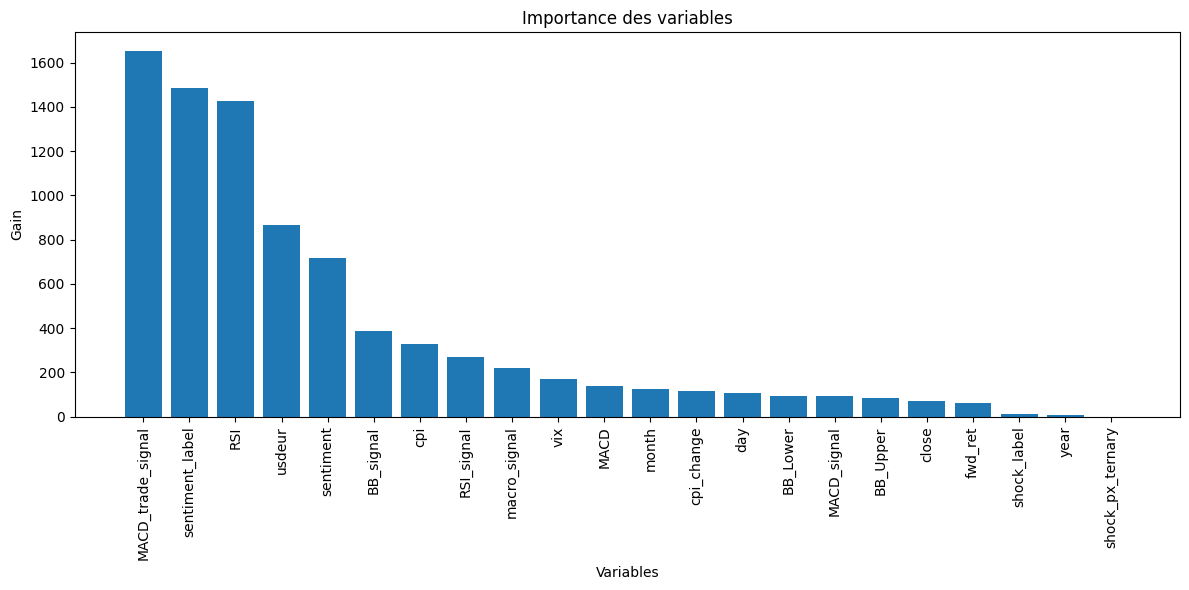

In [ ]:
# Importance des variables : graphique (utilisant matplotlib)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Gain'])
plt.title('Importance des variables')
plt.xlabel('Variables')
plt.ylabel('Gain')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# https://stackoverflow.com/questions/72885619/optuna-hyperparameter-optimization-of-lightgbm-model
# https://www.kaggle.com/code/bjoernholzhauer/lightgbm-tuning-with-optuna


def objective(trial):
    param = {
        'objective': 'multiclass',
        'device': 'cpu',  # 'cuda' possible si GPU dispo
        'boosting': 'gbdt',
        'metric': 'multi_logloss',
        'num_class': 3,  #  car 3 classes
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
        'verbosity': -1,
    }

    lgb_model = lgb.train(
        param,
        train_set=lgb_train,
        valid_sets=[lgb_valid],
        callbacks=[lgb.early_stopping(stopping_rounds=10)],
        num_boost_round=100
    )

    y_pred = lgb_model.predict(X_valid)  # Prédictions de proba shape = (n_samples, 3)
    y_pred_labels = np.argmax(y_pred, axis=1)  # On prend la classe la plus probable

    accuracy = accuracy_score(y_valid, y_pred_labels)
    return accuracy  # Ou return 1.0 - accuracy si tu veux minimiser




In [ ]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=123, n_startup_trials=15),
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=10, n_min_trials=10))


[I 2025-10-06 14:57:25,373] A new study created in memory with name: no-name-4f0624b0-b98c-4af6-9afb-a90e5f4abe6d


In [ ]:
# Fixer des valeurs de départ pour les premiers essais

study.enqueue_trial({
    "learning_rate": 0.1,
    "max_depth": 10,
    "num_leaves": 256
})
study.enqueue_trial({
    "learning_rate": 0.2,
    "max_depth": 12,
    "num_leaves": 128
})
study.enqueue_trial({
    "learning_rate": 0.05,
    "max_depth": 10,
    "num_leaves": 128
})

In [ ]:

study.optimize(objective, timeout=3600, n_trials=100, show_progress_bar = True, gc_after_trial=True)
print('\nNumber of finished trials:', len(study.trials))
print('\nBest trial:', study.best_trial)
print('\nMetric value:', study.best_trial.value)
print('\nBest parameters: ')
for key, value in study.best_trial.params.items():
    print("  {} = {}".format(key,value))

  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.310331
[I 2025-10-06 14:57:25,587] Trial 0 finished with value: 0.9 and parameters: {'max_depth': 10, 'feature_fraction': 0.817881511358717, 'num_leaves': 256, 'learning_rate': 0.1, 'lambda_l1': 0.28613933495037946, 'lambda_l2': 0.2268514535642031}. Best is trial 0 with value: 0.9.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.336212
[I 2025-10-06 14:57:26,183] Trial 1 finished with value: 0.9 and parameters: {'max_depth': 12, 'feature_fraction': 0.7307888614497348, 'num_leaves': 128, 'learning_rate': 0.2, 'lambda_l1': 0.7194689697855631, 'lambda_l2': 0.42310646012446096}. Best is trial 0 with value: 0.9.
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.342174
[I 2025-10-06 14:57:26,792] T

VISUALISATION GRAPHIQUE

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
print(study.best_params)

{'max_depth': 3, 'feature_fraction': 0.8971493164829517, 'num_leaves': 204, 'learning_rate': 0.16180274005726925, 'lambda_l1': 0.025736943606042825, 'lambda_l2': 0.7035026918941253}


METRIC DE PERFORMANCE

In [ ]:
accuracy = study.best_value
classification_error = 1 - accuracy

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Error: {classification_error:.4f}")


Accuracy: 0.9200
Classification Error: 0.0800


In [ ]:
# création du jeu de paramètres optimal qui sera ensuite utilisé pour entraîner le modèle LightGBM

best_params = {
    "objective": "multiclass",
    'num_class': 3,
    "boosting": "gbdt",
    "metric": "multi_logloss",
    "verbosity": -1,
    "seed": 123}
best_params.update(study.best_params)
best_params

{'objective': 'multiclass',
 'num_class': 3,
 'boosting': 'gbdt',
 'metric': 'multi_logloss',
 'verbosity': -1,
 'seed': 123,
 'max_depth': 3,
 'feature_fraction': 0.8971493164829517,
 'num_leaves': 204,
 'learning_rate': 0.16180274005726925,
 'lambda_l1': 0.025736943606042825,
 'lambda_l2': 0.7035026918941253}

In [ ]:
# création du jeu de paramètres optimal qui sera ensuite utilisé pour entraîner le modèle LightGBM

best_params = {
 'objective': 'multiclass',
 'boosting': 'gbdt',
  'num_class': 3,
 'metric': 'multi_logloss',
 'verbosity': -1,
 'seed': 123,
 'max_depth': 12,
 'feature_fraction': 0.4,
 'num_leaves': 512,
 'learning_rate': 0.048091500810963105,
 'lambda_l1': 0.0760432172096489,
 'lambda_l2': 0.006329171720349232}

In [ ]:
best_params = study.best_trial.params

# Ajoute manuellement les paramètres essentiels pour LightGBM multiclasse

best_params['objective'] = 'multiclass'
best_params['metric'] = 'multi_logloss'
best_params['num_class'] = 3


In [ ]:
start_time = time.time()
lgb_model = lgb.train(best_params, lgb_train, valid_sets=[lgb_valid], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=10)])
print("Temps de calcul :", time.time() - start_time)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.297006
Temps de calcul : 0.08578920364379883


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

# Prédiction des probabilités
pred = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)

#  AUC multiclasse
auc = roc_auc_score(y_valid, pred, multi_class='ovr')
print(f"AUC (OvR): {auc:.4f}\n")

#  Classe prédite = probabilité maximale
pred_labels = np.argmax(pred, axis=1)

#  Accuracy
accuracy = accuracy_score(y_valid, pred_labels)
print(f"Accuracy: {accuracy:.4f}\n")

#  Matrice de confusion
conf_matrix = pd.crosstab(pred_labels, y_valid, rownames=['Predicted'], colnames=['Actual'])
print("Confusion Matrix:")
print(conf_matrix)


AUC (OvR): 0.9714

Accuracy: 0.9200

Confusion Matrix:
Actual      0   1   2
Predicted            
0          31   3   0
1           1  24   3
2           0   1  37


In [ ]:
print(test_df.columns)


Index(['date', 'close', 'fwd_ret', 'vix', 'cpi', 'usdeur', 'cpi_change',
       'shock_px_ternary', 'shock_label', 'RSI', 'RSI_signal', 'MACD',
       'MACD_signal', 'MACD_trade_signal', 'BB_Upper', 'BB_Lower', 'BB_signal',
       'macro_signal', 'sentiment', 'sentiment_label', 'final_label', 'year',
       'month', 'day'],
      dtype='object')


In [ ]:
print("Colonnes du modèle :", lgb_model.feature_name())
print("Colonnes X_test :", X_test.columns.tolist())


Colonnes du modèle : ['close', 'fwd_ret', 'vix', 'cpi', 'usdeur', 'cpi_change', 'shock_px_ternary', 'shock_label', 'RSI', 'RSI_signal', 'MACD', 'MACD_signal', 'MACD_trade_signal', 'BB_Upper', 'BB_Lower', 'BB_signal', 'macro_signal', 'sentiment', 'sentiment_label', 'year', 'month', 'day']
Colonnes X_test : ['date', 'close', 'fwd_ret', 'vix', 'cpi', 'usdeur', 'cpi_change', 'shock_px_ternary', 'shock_label', 'RSI', 'RSI_signal', 'MACD', 'MACD_signal', 'MACD_trade_signal', 'BB_Upper', 'BB_Lower', 'BB_signal', 'macro_signal', 'sentiment', 'sentiment_label', 'year', 'month', 'day']


In [ ]:
# Convertir en catégories si pas déjà fait
if test_df['final_label'].dtype.name != 'category':
    test_df['final_label'] = test_df['final_label'].astype('category')


VISUALISATION DE LA PREDICTION SUR LES DONNEES DE TEST

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Étape 1 : Prédiction sur test set 
# X_test a déjà été préparé dans la cellule précédente (ZWodcZe5PI28)

# Ajout d'une étape de nettoyage pour s'assurer que X_test ne contient que des types numériques
X_test_numeric = X_test.select_dtypes(include=np.number)

model_features = lgb_model.feature_name()
X_test_numeric = X_test_numeric[model_features] # Assure l'ordre et la présence des colonnes

pred_prob = lgb_model.predict(X_test_numeric, num_iteration=lgb_model.best_iteration)
pred_labels = np.argmax(pred_prob, axis=1)  # 0=hold, 1=buy, 2=sell

#  Étape 2 : Ajouter les prédictions au DataFrame de test 
# test_df['predicted_signal'] a déjà été ajouté dans la cellule précédente (ZWodcZe5PI28)


#  Étape 3 : Préparer l'index datetime 
# L'index est déjà un datetime index grâce aux modifications précédentes (9mqsBTU__IzX)
# Supprimez la ligne suivante qui cause une erreur car 'year', 'month', 'day' ne sont plus des colonnes:
# test_df.index = pd.to_datetime(test_df[['year', 'month', 'day']]) # REMOVE THIS LINE

test_df.index = pd.to_datetime(test_df.index)


#  Étape 4 : Créer une colonne texte pour le signal (optionnel) 
signal_map = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
test_df['signal_text'] = test_df['predicted_signal'].map(signal_map)

#  Étape 5 : Tracer avec plotly pour interactivité 
fig = go.Figure()

# Trace de la courbe close
fig.add_trace(go.Scatter(
    x=test_df.index,
    y=test_df['close'],
    mode='lines',
    name='Cours Close',
    line=dict(color='black')
))

# Signaux Buy (flèche vers le haut)
fig.add_trace(go.Scatter(
    x=test_df[test_df['predicted_signal'] == 1].index,
    y=test_df[test_df['predicted_signal'] == 1]['close'],
    mode='markers',
    name='Buy',
    marker=dict(symbol='triangle-up', color='green', size=12)
))

# Signaux Sell (flèche vers le bas)
fig.add_trace(go.Scatter(
    x=test_df[test_df['predicted_signal'] == 2].index,
    y=test_df[test_df['predicted_signal'] == 2]['close'],
    mode='markers',
    name='Sell',
    marker=dict(symbol='triangle-down', color='red', size=12)
))

# Ligne colorée en bas pour visualiser la position (hold/buy/sell)
base_level = test_df['close'].min() * 0.98
colors = test_df['predicted_signal'].map({0: 'gray', 1: 'green', 2: 'red'})

fig.add_trace(go.Scatter(
    x=test_df.index,
    y=[base_level] * len(test_df),
    mode='markers',
    name='Positions',
    marker=dict(color=colors, size=8, opacity=0.6),
    showlegend=True
))

# Mise en forme finale
fig.update_layout(
    title="Stratégie Trading Daily - Signaux Buy/Sell sur S&P (Test Set)",
    xaxis_title="Date",
    yaxis_title="Prix Close",
    hovermode='x unified',
    legend=dict(x=0, y=1.1, orientation='h')
)

# Zoom par défaut sur une période (décommente et adapte si besoin)
 #fig.update_xaxes(range=[pd.to_datetime('2018-07-04'), pd.to_datetime('2020-03-31')])

fig.show()

In [ ]:
print(X_train)

                  close   fwd_ret    vix      cpi  usdeur  cpi_change  \
date                                                                    
2018-01-04  2723.989990  0.007034   9.22      NaN  1.2064    0.004253   
2018-01-08  2747.709961  0.001303   9.52      NaN  1.1973    0.004253   
2018-01-10  2748.229980  0.007034   9.82      NaN  1.1958    0.004253   
2018-01-11  2767.560059  0.006750   9.88      NaN  1.2035    0.004253   
2018-01-16  2776.419922  0.009415  11.66      NaN  1.2244    0.004253   
...                 ...       ...    ...      ...     ...         ...   
2020-07-10  3185.040039 -0.009363  27.29  258.352  1.1318    0.005096   
2020-07-13  3155.219971  0.013406  32.19  258.352  1.1364    0.005096   
2020-07-14  3197.520020  0.009082  29.52  258.352  1.1406    0.005096   
2020-07-16  3215.570068  0.002849  28.00  258.352  1.1433    0.005096   
2020-07-17  3224.729980  0.008407  25.68  258.352  1.1438    0.005096   

            shock_px_ternary  shock_label        R

In [ ]:
print(train_df)

                  close   fwd_ret    vix      cpi  usdeur  cpi_change  \
date                                                                    
2018-01-04  2723.989990  0.007034   9.22      NaN  1.2064    0.004253   
2018-01-08  2747.709961  0.001303   9.52      NaN  1.1973    0.004253   
2018-01-10  2748.229980  0.007034   9.82      NaN  1.1958    0.004253   
2018-01-11  2767.560059  0.006750   9.88      NaN  1.2035    0.004253   
2018-01-16  2776.419922  0.009415  11.66      NaN  1.2244    0.004253   
...                 ...       ...    ...      ...     ...         ...   
2020-07-10  3185.040039 -0.009363  27.29  258.352  1.1318    0.005096   
2020-07-13  3155.219971  0.013406  32.19  258.352  1.1364    0.005096   
2020-07-14  3197.520020  0.009082  29.52  258.352  1.1406    0.005096   
2020-07-16  3215.570068  0.002849  28.00  258.352  1.1433    0.005096   
2020-07-17  3224.729980  0.008407  25.68  258.352  1.1438    0.005096   

            shock_px_ternary  shock_label        R

In [ ]:
print(test_df)

                 date        close   fwd_ret    vix      cpi  usdeur  \
2018-01-02 2018-01-02  2695.810059  0.006399   9.77      NaN  1.2050   
2018-01-03 2018-01-03  2713.060059  0.004029   9.15      NaN  1.2030   
2018-01-05 2018-01-05  2743.149902  0.001662   9.22      NaN  1.2039   
2018-01-12 2018-01-12  2786.239990 -0.003524  10.16      NaN  1.2130   
2018-01-15 2018-01-15  2786.239990 -0.003524  10.16      NaN  1.2130   
...               ...          ...       ...    ...      ...     ...   
2020-06-19 2020-06-19  3097.739990  0.006495  35.12  257.042  1.1189   
2020-06-23 2020-06-23  3131.290039 -0.025855  31.37  257.042  1.1322   
2020-06-29 2020-06-29  3053.239990  0.015410  31.78  257.042  1.1237   
2020-07-03 2020-07-03  3130.010010  0.015882  27.68  258.352  1.1237   
2020-07-08 2020-07-08  3169.939941 -0.005644  28.08  258.352  1.1329   

            cpi_change  shock_px_ternary  shock_label        RSI  ...  \
2018-01-02    0.004253                 0            0        N